In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-colorblind')
import tensorflow as tf
import numpy as np
import tensorflow_probability as tfp
import tensorflow.distributions as tfd

np.set_printoptions(precision=2,
                    edgeitems=3,
                    linewidth=80,
                    suppress=True)


tf.enable_eager_execution()

In [2]:
rho = 0.95
C = np.float32(np.eye(N=2) + rho * np.eye(N=2)[::-1])
print(C)

p_x = tfp.distributions.MultivariateNormalTriL(scale_tril=tf.cholesky([[1.0,.95],[.95,1.0]]))

[[1.   0.95]
 [0.95 1.  ]]


In [3]:
u1_lim = -3., 3.   # -2.5, 2.5
u2_lim = -10., 2. # -7.0, 2.0
log_num = 10  # base 2
u1 = tf.linspace(*u1_lim, num=1 << log_num)
u2 = tf.linspace(*u2_lim, num=1 << log_num)
u_grid = tf.stack(tf.meshgrid(u1, u2), axis=-1)

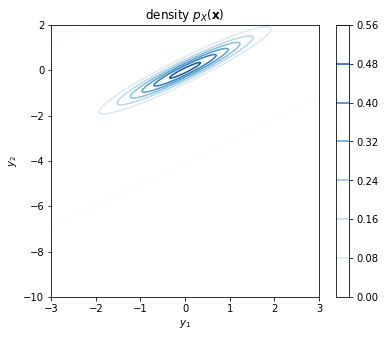

In [4]:
fig, ax = plt.subplots(figsize=(6, 5))

ax.set_title('density $p_{X}(\mathbf{x})$')

cb = ax.contour(u1, u2, p_x.prob(u_grid), cmap='Blues')

fig.colorbar(cb, ax=ax)

ax.set_xlim(u1_lim)
ax.set_ylim(u2_lim)

ax.set_xlabel('$y_1$')
ax.set_ylabel('$y_2$')

plt.show()

In [5]:
samples = p_x.sample(1000)
print(samples)

tf.Tensor(
[[-0.59 -0.37]
 [ 0.5   0.69]
 [ 0.02  0.16]
 ...
 [ 0.87  0.7 ]
 [ 2.16  2.27]
 [-0.09 -0.65]], shape=(1000, 2), dtype=float32)


In [6]:
def forward_(samples):
    y1= samples[...,0:1]
    y2= samples[...,1:2] - (y1**2)  -1
    return tf.concat([y1,y2],axis=-1)

In [7]:
y = forward_(samples)

In [8]:
p_x.sample(11)

<tf.Tensor: id=341, shape=(11, 2), dtype=float32, numpy=
array([[-0.17,  0.24],
       [ 2.08,  1.43],
       [-0.37,  0.01],
       [ 0.91,  0.64],
       [ 2.02,  1.97],
       [-0.52, -0.47],
       [ 0.32,  0.43],
       [ 2.32,  2.12],
       [ 0.15,  0.16],
       [ 0.14, -0.13],
       [ 0.24,  0.49]], dtype=float32)>

# Bijector Class

In [9]:
class Banana(tfp.bijectors.Bijector):
    def __init__(self,name="Banana"):
        super(Banana,self).__init__(inverse_min_event_ndims=1,is_constant_jacobian=True,name=name).__init__()
            
    
    def _forward(self,x):
        y_0 = x[..., 0:1]
        y_1 = x[..., 1:2] - y_0**2 - 1
        y_tail = x[..., 2:-1]
        return tf.concat([y_0, y_1, y_tail], axis=-1)
    
    
    def _inverse(self,y):
        x_0 = y[..., 0:1]
        x_1 = y[..., 1:2] + x_0**2 + 1
        x_tail = y[..., 2:-1]
        return tf.concat([x_0, x_1, x_tail], axis=-1)
    
    
    def _inverse_log_det_jacobian(self, y):
        return tf.zeros(shape=())

In [10]:
p_y = tfp.distributions.TransformedDistribution(
    distribution=p_x,
    bijector= Banana()
)

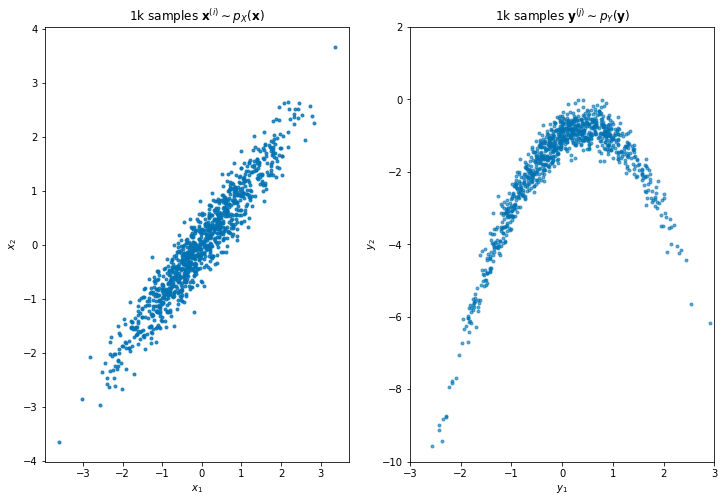

In [11]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 8))

ax1.set_title('1k samples $\mathbf{x}^{(i)} \sim p_{X}(\mathbf{x})$')
s = p_x.sample(1000)
ax1.plot(s[:,0],s[:,1], '.', alpha=.8, rasterized=True)

#ax1.set_xlim([-4,1])
#ax1.set_ylim(u2_lim)

ax1.set_xlabel('$x_1$')
ax1.set_ylabel('$x_2$')

ax2.set_title('1k samples $\mathbf{y}^{(j)} \sim p_{Y}(\mathbf{y})$')
d = p_y.sample(1000)
ax2.plot(d[:,0],d[:,1], '.', alpha=.6, rasterized=True)

ax2.set_xlim(u1_lim)
ax2.set_ylim(u2_lim)

ax2.set_xlabel('$y_1$')
ax2.set_ylabel('$y_2$')

plt.show()
# plt.savefig('banana_base_samples.svg', format='svg', dpi=1200)

### Plot Contours

In [12]:
log_num = 11
u1_lim = -3., 3.   # -2.5, 2.5
u2_lim = -10., 2. # -7.0, 2.0

In [13]:
u1 = tf.linspace(*u1_lim, num=1 << log_num)
u2 = tf.linspace(*u2_lim, num=1 << log_num)
udata = np.stack(tf.meshgrid(u1,u2),axis=-1)

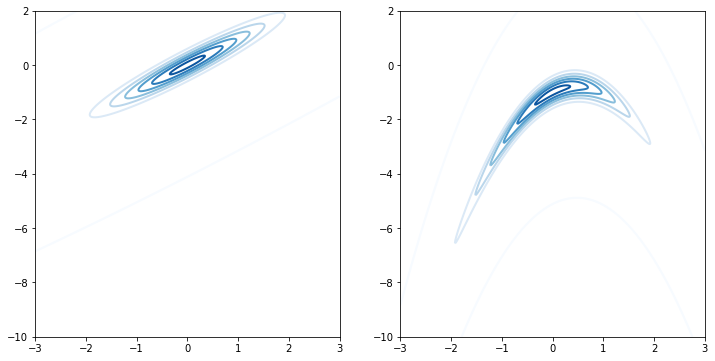

In [14]:
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.contour(u1,u2,p_x.prob(udata),cmap='Blues',linewidths=2)
plt.subplot(122)
plt.contour(u1,u2,p_y.prob(udata),cmap='Blues',linewidths=2)

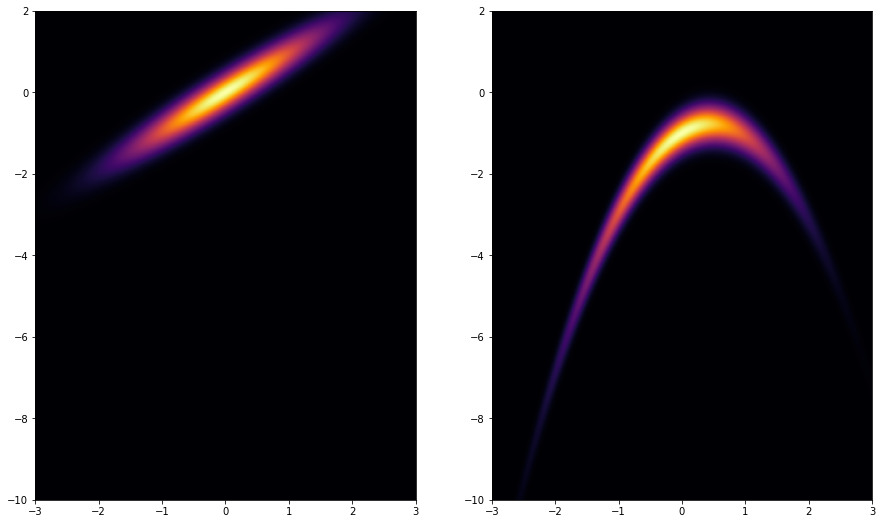

In [15]:

plt.figure(figsize=(15,9),facecolor=(1, 1, 1))
plt.subplot(121)
plt.pcolormesh(u1,u2,p_x.prob(udata),cmap='inferno',linewidths=2);
plt.subplot(122)
plt.pcolormesh(u1,u2,p_y.prob(udata),cmap='inferno',linewidths=2);


In [18]:
#checking bijector properties
b= Banana()

In [21]:
a = b.forward([.4,.7])
print(a)
print(b.inverse(a))

tf.Tensor([ 0.4  -0.46], shape=(2,), dtype=float32)
tf.Tensor([0.4 0.7], shape=(2,), dtype=float32)


In [ ]:
b.inverse_log_det_jacobian()